In [1]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
from scipy.io import loadmat
from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

## Veri setimizi yüklüyoruz
Burada veri setimi tek bir fonksiyonda yüklemeye çalıştım ancak hata aldım sonradan düzelteceğim ve tek programda toplayacağım

In [2]:
#def loadmat(name):
X=loadmat('/Users/Furkan/Downloads/HSI/HSI_Class/DL_class/PaviaU.mat')['paviaU']
y=loadmat('/Users/Furkan/Downloads/HSI/HSI_Class/DL_class/PaviaU_gt.mat')['paviaU_gt']

## Test_Ratio ve pixelsize belirliyoruz.
 # test_ratio: veri setimizin ne kadarını test için ayıracağımızı belirtiyor.
 # pixelsize: verisetimizdeki görüntü(ler) keras ile oluşturduğumuz CNNler içinde kullanabilmesi için reshape ile çözünürlüğünü değişmemiz gerekiyor

In [3]:
dataset='PU'
test_ratio=0.3
pixelsize=25

In [4]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

Train test spliti yapıyoruz.


In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

PCA (Temel Bileşen Analizi) kullanarak verisetimizi sıkıştırıyoruz.
PCA sıkışan verimizdeki kaybın olabildiğince minimal olmasını sağlıyor

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

## Görüntüleri küp şekle ayırıyoruz.
**Keras modulu içine vereceğimiz verilerin şeklini küp veya kare olarak verilmesini ister bizler 3D cnn kullandığımız için burada görüntülerimizden bir bakıma küp küp çıktılar alacağız.**
*Bu kısım bir nevi verisetimizin kerasa optimizasyonunu sağlıyor. 

In [7]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [8]:
X.shape, y.shape

((610, 340, 103), (610, 340))

In [9]:
K=X.shape[2]
K

103

In [10]:
X,pca=applyPCA(X,numComponents=15)
X.shape

(610, 340, 15)

In [11]:
X, y = createImageCubes(X, y, windowSize=25)

X.shape, y.shape

((42776, 25, 25, 15), (42776,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((29943, 25, 25, 15), (12833, 25, 25, 15), (29943,), (12833,))

***Train datamızı yukarıda ayırmıştık şimdi ayırdığımız train datasını ilk etapta test edebilmek için validation datasına ayırıyoruz ratio=0.33***

**Özellikle çok büyük veri setleri üzerinde sürekli Train datası üzerinden çalışılamayacağı için küçük bir bölüm alınarak validation olarak tanımlanır.**


In [13]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((19962, 25, 25, 15), (9981, 25, 25, 15), (19962,), (9981,))

In [14]:
Xtrain = Xtrain.reshape(-1, pixelsize, pixelsize, 15, 1)
Xtrain.shape

(19962, 25, 25, 15, 1)

In [15]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(19962, 9)

In [16]:
Xvalid = Xvalid.reshape(-1, pixelsize, pixelsize, 15, 1) 
Xvalid.shape

(9981, 25, 25, 15, 1)

In [17]:
yvalid=np_utils.to_categorical(yvalid)
yvalid.shape

(9981, 9)

# CNN modelimizi oluşturuyoruz.

In [18]:
input_layer=Input((25,25,15,1))
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
flatten_layer = Flatten()(conv_layer4)
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=9, activation='softmax')(dense_layer2)

(None, 19, 19, 3, 32)


In [19]:
model=Model(inputs=input_layer,outputs=output_layer)


# *Modelimizin özetini bastırıyoruz*

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 15, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 9, 8)      512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 5, 16)     5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 3, 32)     13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 96)        0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        55360     
                                                                 
 flatten (Flatten)           (None, 18496)             0     

# *Adam optimizeri kullanıyoruz metric olarak accuracy kullanıyoruz.*

In [21]:
adam=Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

# Oluşturduğumuz modeli kayıt ediyoruz.

In [22]:
filepath = "best-model.hdf5"
metric='acc'
checkpoint=ModelCheckpoint(filepath=filepath,monitor=metric,verbose=1,save_best_only=True,mode='max')
callback_list=[checkpoint]

# Model fitleme epoch=10 (göstermek için sonradan değişecek 50,100,200,250 değerleri ile sonuç değişimis kayıt edilecek)

In [23]:
history=model.fit(x=Xtrain,y=ytrain,validation_data=(Xvalid,yvalid),batch_size=256,epochs=5,callbacks=callback_list)

Epoch 1/5
78/78 [==============================] - 165s 2s/step - loss: 0.6611 - accuracy: 0.7643 - val_loss: 0.0296 - val_accuracy: 0.9916
Epoch 2/5
78/78 [==============================] - 131s 2s/step - loss: 0.0578 - accuracy: 0.9821 - val_loss: 0.0196 - val_accuracy: 0.9937
Epoch 3/5
78/78 [==============================] - 130s 2s/step - loss: 0.0207 - accuracy: 0.9940 - val_loss: 0.0027 - val_accuracy: 0.9992
Epoch 4/5
78/78 [==============================] - 129s 2s/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.0013 - val_accuracy: 0.9996
Epoch 5/5
78/78 [==============================] - 129s 2s/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.0097 - val_accuracy: 0.9982


In [24]:
model.save("best-model1.hdf5")

Sonuçların grafik ile gösterimi

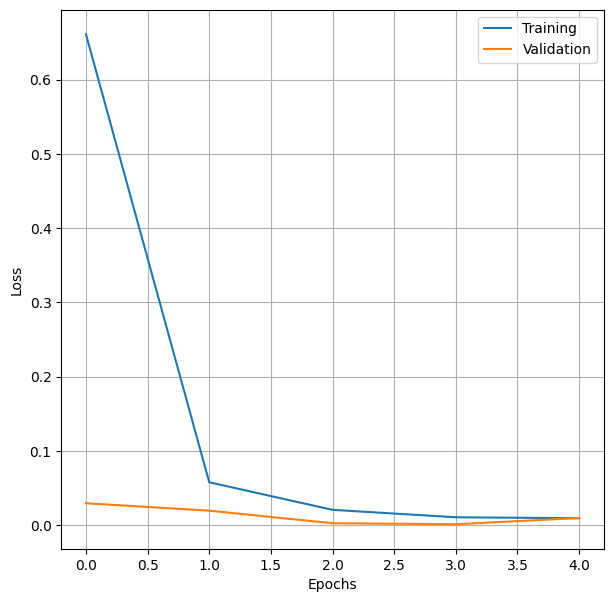

In [25]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss') 
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right') 
plt.savefig("PAVIA_loss_curve.pdf") 
plt.show()



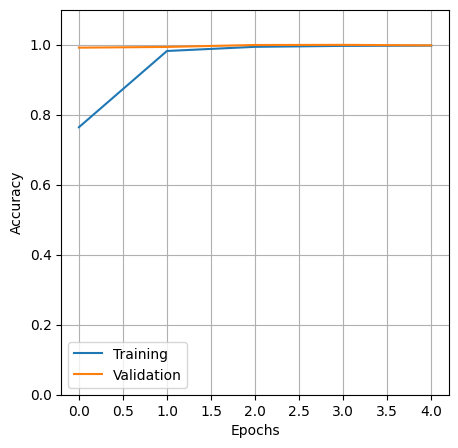

In [26]:
plt.figure(figsize=(5,5)) 
plt.ylim(0,1.1) 
plt.grid() 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Validation']) 
plt.savefig("PAVIA_acc_curve.pdf") 
plt.show()

# Modeli test etmek için modeli yüklüyoruz.

In [27]:
model.load_weights=("best-model1.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [28]:
Xtest=Xtest.reshape(-1,pixelsize,pixelsize,15,1)
Xtest.shape

(12833, 25, 25, 15, 1)

In [29]:
ytest=np_utils.to_categorical(ytest)
ytest.shape

(12833, 9)

In [30]:
Y_pred_test=model.predict(Xtest)
Y_pred_test=np.argmax(Y_pred_test,axis=1)
classification= classification_report(np.argmax(ytest,axis=1),Y_pred_test)
print(classification)

402/402 [==============================] - 16s 39ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1989
           1       1.00      1.00      1.00      5595
           2       1.00      1.00      1.00       630
           3       1.00      1.00      1.00       919
           4       0.95      1.00      0.98       403
           5       1.00      1.00      1.00      1509
           6       1.00      1.00      1.00       399
           7       1.00      1.00      1.00      1105
           8       1.00      0.92      0.96       284

    accuracy                           1.00     12833
   macro avg       0.99      0.99      0.99     12833
weighted avg       1.00      1.00      1.00     12833



In [31]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter= confusion_matrix[0]
    list_diag= np.diag(confusion_matrix)
    list_raw_sum= np.sum(confusion_matrix,axis=1)
    each_acc=np.nan_to_num(truediv(list_diag,list_raw_sum))
    average_acc=np.mean(each_acc)
    return each_acc, average_acc

In [32]:
import time 
def reports(X_test,y_test,name):
    start=time.time()
    Y_pred=model.predict(X_test)
    y_pred=np.argmax(Y_pred,axis=1)
    end=time.time()
    print(end-start)
    target_names=['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen','Self-Blocking Bricks','Shadows']
    classification=classification_report(np.argmax(y_test,axis=1),y_pred,target_names=target_names)
    oa=accuracy_score(np.argmax(y_test,axis=1),y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [33]:
import os 
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "PAVIA_classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

402/402 [==============================] - 16s 39ms/step
16.29429817199707
402/402 [==============================] - 17s 41ms/step - loss: 0.0086 - accuracy: 0.9978


In [34]:
def Patch(data,height_index,width_index):
    height_slice=slice(height_index,height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [35]:
X=loadmat('/Users/Furkan/Downloads/HSI/HSI_Class/DL_class/PaviaU.mat')['paviaU']
y=loadmat('/Users/Furkan/Downloads/HSI/HSI_Class/DL_class/PaviaU_gt.mat')['paviaU_gt']

In [36]:
height=y.shape[0]
weidth=y.shape[1]
PATCH_SIZE=25
numComponents=15

In [37]:
X,pca=applyPCA(X,numComponents=numComponents)


In [38]:
X=padWithZeros(X,PATCH_SIZE//2)


In [39]:
outputs=np.zeros((height,weidth))
for i in range (height):
    for j in range (weidth):
        target=int(y[i,j])
        if target==0:
            continue
        else:
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction=(model.predict(X_test_image))
            prediction=np.argmax(prediction,axis=1)
            outputs[i][j]=prediction+1

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 198ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 50ms/step


In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))


In [ ]:
spectral.save_rgb("PAVIA_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
